# Overlay rails map with area of interest

Notes on the rail buffering:
- round style prevents breaks in the buffers
- USA uses standard track guage (https://en.wikipedia.org/wiki/Track_gauge_in_the_United_States), which is about 1.5m wide

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, box, LineString
from shapely import intersection
from tqdm.notebook import tqdm

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

In [2]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
fn_rails = '/Volumes/Extreme SSD/largest_plots/raw_data/tl_2023_us_rails.zip'
fn_rail_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/rails_overlay.parquet'

In [3]:
Aoi = gpd.read_parquet(fn_aoi)
Rails = gpd.read_file(fn_rails).to_crs(epsg=target_epsg)

# Transform linear rails to polygons

In [5]:
RailPolygons = Rails[['geometry']].buffer(distance=0.75, cap_style='round')
RailPolygons = RailPolygons.to_frame().rename(columns={0:'geometry'})
RailPolygons.set_geometry('geometry', inplace=True)
RailPolygons.head()

,geometry
0,"POLYGON ((1480145.928 1505645.640, 1480145.934..."
1,"POLYGON ((1480270.626 1505901.408, 1480270.611..."
2,"POLYGON ((1480369.404 1506230.074, 1480446.390..."
3,"POLYGON ((1489683.637 1470829.123, 1489691.628..."
4,"POLYGON ((1486906.929 1462856.479, 1486906.930..."


In [6]:
RailPolygons.shape[0] == Rails.shape[0]

True

# Look for overlaps

## Manually do this, to make sure it works conceptually

In [7]:
i = 30
single_aoi = Aoi.loc[[i]]
RailSubset = gpd.sjoin(RailPolygons, single_aoi, how='inner', predicate='intersects')
rail_polygon_flat = RailSubset.unary_union
rail_overlay = single_aoi.intersection(rail_polygon_flat)

<Axes: >

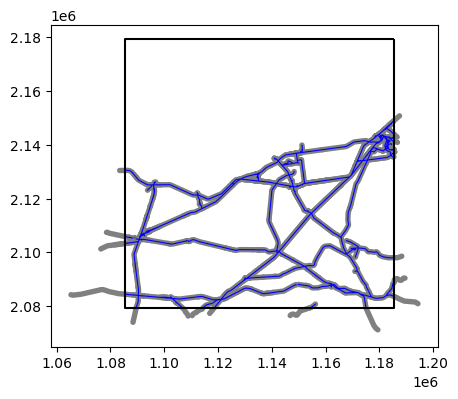

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
single_aoi.boundary.plot(ax=ax, color='black')  # our AOI
RailSubset.buffer(distance=1000).plot(ax=ax, color='grey')  # All offending lines
# gpd.GeoSeries(rail_polygon_flat).buffer(distance=500).plot(ax=ax, color='blue')
gpd.GeoSeries(rail_overlay).buffer(distance=200).plot(ax=ax, color='blue')  # All offending lines that are within the AOI  

In [18]:
# Important exception!
# If we try to find an overlap with a point in the ocean, we get an empty table.
minx, miny, maxx, maxy = Rails.total_bounds
foreign_aoi = Point((minx - 500, miny - 500))
foreign_aoi = foreign_aoi.buffer(distance=10)
foreign_aoi = gpd.GeoSeries(foreign_point).to_frame().set_crs(target_epsg)
gpd.sjoin(RailPolygons, foreign_aoi, how='inner', predicate='intersects').shape[0]

0

## Iterate

In [84]:
overlay_dict = {}
for i in tqdm(Aoi.index):
    single_aoi = Aoi.loc[[i]]
    
    RailSubset = gpd.sjoin(RailPolygons, single_aoi, how='inner', predicate='intersects')
    if RailSubset.shape[0] > 0:
        rail_polygon_flat = RailSubset.unary_union
        rail_overlay = single_aoi.intersection(rail_polygon_flat)    
        rail_overlay = rail_overlay.to_frame().reset_index(drop=True).loc[0,0]  # the prev line returns a series-- get the singular value therefrom
        overlay_dict[i] = rail_overlay
    else:
        pass

  0%|          | 0/56 [00:00<?, ?it/s]

In [63]:
# Were all AOIs properly munged, ie, no intersections with zero rows?
len(overlay_dict.keys()) == Aoi.shape[0]

True

In [109]:
RailOverlay = gpd.GeoDataFrame({'index':overlay_dict.keys(), 'geometry':overlay_dict.values()}, crs='epsg:'+str(target_epsg))
RailOverlay.set_index('index', drop=True, inplace=True, verify_integrity=True)
RailOverlay.set_geometry('geometry')
RailOverlay.head()

,geometry
index,
0,"MULTIPOLYGON (((1064783.733 1250048.001, 10645..."
1,"MULTIPOLYGON (((1253970.757 1239594.718, 12539..."
2,"MULTIPOLYGON (((1280030.297 1411939.881, 12799..."
3,"MULTIPOLYGON (((1652992.164 1554821.848, 16523..."
4,"MULTIPOLYGON (((1517647.954 1454414.009, 15175..."


In [110]:
RailOverlay.to_parquet(fn_rail_overlay)